In [1]:
import glob, os, sys
sys.path.append("..")
from utils.utils import *
import uproot, ROOT, random, time, vector
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import json
from sklearn.metrics import roc_curve, roc_auc_score, auc
from tqdm import tqdm
import pandas as pd
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from xgboost import XGBClassifier

# Set up plot defaults
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font
sns.set(style="whitegrid")

Welcome to JupyROOT 6.28/04


In [2]:
Ztt_inc_dsid = [
    # mc23 DSIDs
    # 700621, 700622, 700623, 
    # 700642, 700643, 700644,
    # 700703, 700704, 700705,
    # mc20 DSIDs
    700792, 700793, 700794,
    700360, # Ztautau2jets
    ]
ttV_dsid = [
    410155, # ttW
    410218, 410219, 410220, # ttZ
    304014, 410220 # 3t, 4t #! missing these samples
    ]

# Diboson
VV_dsid = [
    700488, 700489, 
    700491, 700492, 700493, 700494, 700495, 700496,
    700600, 700601, 700602, 700603, 700604, 700605, 
]

# Single-Top and ttbar (new samples now!)
Top_dsid = [
    410470, 410471, 
    # 410472, 
    410644, 410645, 410646, 410647, 
    410658, 410659
]

# W(tau/mu/e + nu) + jets
W_dsid = [
    700338, 700339, 700340, # Wenu
    700341, 700342, 700343, # Wmunus
    700344, 700345, 700346, # WtaunuL
    700347, 700348, 700349, # WtaunuH #! should these be included? are these signal?
    700362, 700363, 700364, # W lep + 2jets
]

Zll_inc_dsid = [
    700320, 700321, 700322, # Zee 
    700323, 700324, 700325, # Zmumu
    700358, #Zee2jets
    700359, #Zmumu2jets
]

# Signal samples (new)
ggH_dsid = [
    # mc23 DSIDs
    # 601578, 601579, 601580, 601581, 
    # mc20 DSIDs
    345120, 345122, 345123, 345121
    ]
VBFH_dsid = [
    # mc20 DSIDs
    346190, 346191, 346192, 346193,
]
WH_dsid = [345211, 345212]
ZH_dsid = [345217]
ttH_dsid = [346343,346344,346345]


In [3]:
def read_event_weights(event_id, data_year):
    file_path = './xsec_sumofweights_nom.json'
    # Load the data from the JSON file
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Get the list of events from the key 'ditau_hh' under 'mc20a'
    events = data.get(data_year, {}).get('ditau_hh', [])

    # Iterate over each event in the list
    for event in events:
        # Check if the first element (ID) matches the provided event_id
        if event[0] == event_id:
            # Return the second (event weight) and third (sum of event weights) elements
            return (event[1], event[2])
    
    # If no matching ID is found, return None for both values
    return (None, None)

def fetch_weights(id_list, data_year):
    results = {}
    for event_id in id_list:
        event_weight, sum_event_weights = read_event_weights(event_id, data_year)
        if event_weight is None:
            print(event_id, "weights filled with one")
            results[event_id] = 1
        else: 
            results[event_id] = event_weight / sum_event_weights
    return results
            
#signal
vbfh_ws = fetch_weights(VBFH_dsid, 'mc20e')
ggh_ws = fetch_weights(ggH_dsid, 'mc20e')
wh_ws = fetch_weights(WH_dsid, 'mc20e')
zh_ws = fetch_weights(ZH_dsid, 'mc20e')
tth_ws = fetch_weights(ttH_dsid, 'mc20e')

#background
ztt_ws = fetch_weights(Ztt_inc_dsid, 'mc20e')
ttv_ws = fetch_weights(ttV_dsid, 'mc20e')
vv_ws = fetch_weights(VV_dsid, 'mc20e')
top_ws = fetch_weights(Top_dsid, 'mc20e')
w_ws = fetch_weights(W_dsid, 'mc20e')
zll_ws = fetch_weights(Zll_inc_dsid, 'mc20e')

In [4]:
branches = \
['HLT_j420',
 'HLT_j420_a10t_lcw_jes_35smcINF_L1J100',
 'HLT_j420_a10t_lcw_jes_35smcINF_L1SC111',
 'ditau_obj_IsTruthHadronic',
 'ditau_obj_IsTruthMatched',
#  'boson_0_p4',
 'ditau_obj_truth_p4',
 'jets_b_tag_score',
#  'ditau_obj_R_jet',
#  'ditau_obj_R_subjet',
#  'ditau_obj_Rr_core',
 'ditau_obj_bdt_score',
#  'ditau_obj_charge',
 'ditau_obj_leadsubjet_charge',
 'ditau_obj_leadsubjet_n_core_tracks',
 'ditau_obj_leadsubjet_p4',
 'ditau_obj_nSubjets',
#  'ditau_obj_n_iso_tracks',
 'ditau_obj_n_tracks',
 'ditau_obj_p4',
#  'ditau_obj_subjets_dR',
 'ditau_obj_subleadsubjet_charge',
 'ditau_obj_subleadsubjet_n_core_tracks',
 'ditau_obj_subleadsubjet_p4',
#  'ditau_obj_tauJetVtxFraction',
 # 'missing_pt',
 # 'ditau_visible_mass',
#  'jets_p4',
#  'ditau_obj_truth_leadTau_p4',
#  'ditau_obj_truth_p4',
#  'ditau_obj_truth_subleadTau_p4',
 'ditau_obj_mvis_recalc',
 'event_number',
 'met_p4',
 'met_sumet',
 'met_hpto_p4',
 'met_hpto_test_p4',
 'met_hpto_dr_wrt_jets',
 'met_hpto_dr_wrt_taus',
 'met_truth_p4',
 'event_is_bad_batman',
 'NOMINAL_pileup_combined_weight',
 'n_bjets_DL1dv01_FixedCutBEff_70',
 'weight_mc']

data_branches = \
['HLT_j420',
 'event_number',    
 'HLT_j420_a10t_lcw_jes_35smcINF_L1J100',
 'HLT_j420_a10t_lcw_jes_35smcINF_L1SC111',
 'ditau_obj_mvis_recalc',
 'met_p4',
 'met_sumet',
 'met_hpto_p4',
 'met_hpto_test_p4',
 'met_hpto_dr_wrt_jets',
 'met_hpto_dr_wrt_taus',
 'met_truth_p4',
 'event_is_bad_batman',
 'jets_b_tag_score',
 'ditau_obj_bdt_score',
 'ditau_obj_leadsubjet_charge',
 'ditau_obj_leadsubjet_n_core_tracks',
 'ditau_obj_leadsubjet_p4',
 'ditau_obj_nSubjets',
 'ditau_obj_n_tracks',
 'ditau_obj_p4',
 'ditau_obj_subleadsubjet_charge',
 'ditau_obj_subleadsubjet_n_core_tracks',
 'ditau_obj_subleadsubjet_p4',
 'n_bjets_DL1dv01_FixedCutBEff_70']

In [5]:
path_template = '/global/homes/a/agarabag/pscratch/ditdau_samples/v06/mc/ditau_hh/mc20e/nom/user.shhirose.*{dsid}.*/user.*.root'

def read_root(dsid_list, mc_ws):
    out = []
    for dsid in dsid_list:
        # Using wildcard pattern around the DSID
        file_pattern = path_template.format(dsid=dsid)
        files = glob.glob(file_pattern)
        s = time.time()
        for file in files:
            with uproot.open(file + ':NOMINAL') as f_1:
                events = f_1.arrays(branches, library='ak')
                events['weight'] = mc_ws[dsid] * ak.ones_like(events['ditau_obj_n_tracks'])
                out = ak.concatenate((out, events))
        print("Processed:", len(files), "files for DSID", dsid, "Time spent:", round(time.time()-s, 4), 's')
    return out

vbfh = read_root(VBFH_dsid, vbfh_ws)
ggh = read_root(ggH_dsid, ggh_ws)
wh = read_root(WH_dsid, wh_ws)
zh = read_root(ZH_dsid, zh_ws)
tth = read_root(ttH_dsid, tth_ws)

ztt = read_root(Ztt_inc_dsid, ztt_ws)
ttv = read_root(ttV_dsid, ttv_ws)
vv = read_root(VV_dsid, vv_ws)
top = read_root(Top_dsid, top_ws)
w = read_root(W_dsid, w_ws)
zll = read_root(Zll_inc_dsid, zll_ws)

Processed: 1 files for DSID 346190 Time spent: 0.1744 s
Processed: 1 files for DSID 346191 Time spent: 0.2433 s
Processed: 1 files for DSID 346192 Time spent: 0.173 s
Processed: 1 files for DSID 346193 Time spent: 0.345 s
Processed: 3 files for DSID 345120 Time spent: 0.5782 s
Processed: 2 files for DSID 345122 Time spent: 0.4333 s
Processed: 2 files for DSID 345123 Time spent: 0.4285 s
Processed: 2 files for DSID 345121 Time spent: 0.4541 s
Processed: 1 files for DSID 345211 Time spent: 0.1618 s
Processed: 1 files for DSID 345212 Time spent: 0.1683 s
Processed: 1 files for DSID 345217 Time spent: 0.2978 s
Processed: 3 files for DSID 346343 Time spent: 0.6928 s
Processed: 1 files for DSID 346344 Time spent: 0.2332 s
Processed: 1 files for DSID 346345 Time spent: 0.1982 s
Processed: 8 files for DSID 700792 Time spent: 3.1195 s
Processed: 6 files for DSID 700793 Time spent: 4.8157 s
Processed: 36 files for DSID 700794 Time spent: 20.8671 s
Processed: 2 files for DSID 700360 Time spent: 0

In [6]:
## load data
path_template_data = '/global/homes/a/agarabag/pscratch/ditdau_samples/v06/data/ditau_hh/data18/user.shhirose.Httbst_b6.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p5855.smPre_w_1_HS/*.root'

def read_data_root(file_paths):
    out = []
    l1 = glob.glob(file_paths)
    s = time.time()
    for i in range(len(l1)):
        print("reading: ", l1[i])
        f_1 = uproot.open(l1[i]+':NOMINAL')
        events = f_1.arrays(data_branches, library='ak')
        out = ak.concatenate((events, out))
    print("processed: ", l1[i], "time spent", round(time.time()-s, 4), 's')
    return out

data = read_data_root(path_template_data)


reading:  /global/homes/a/agarabag/pscratch/ditdau_samples/v06/data/ditau_hh/data18/user.shhirose.Httbst_b6.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p5855.smPre_w_1_HS/user.shhirose.38631345._000178.HSM_common.root


reading:  /global/homes/a/agarabag/pscratch/ditdau_samples/v06/data/ditau_hh/data18/user.shhirose.Httbst_b6.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p5855.smPre_w_1_HS/user.shhirose.38631345._000165.HSM_common.root
reading:  /global/homes/a/agarabag/pscratch/ditdau_samples/v06/data/ditau_hh/data18/user.shhirose.Httbst_b6.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p5855.smPre_w_1_HS/user.shhirose.38631345._000156.HSM_common.root
reading:  /global/homes/a/agarabag/pscratch/ditdau_samples/v06/data/ditau_hh/data18/user.shhirose.Httbst_b6.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p5855.smPre_w_1_HS/user.shhirose.38631345._000101.HSM_common.root
reading:  /global/homes/a/agarabag/pscratch/ditdau_samples/v06/data/ditau_hh/data18/user.shhirose.Httbst_b6.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p5855.smPre_w_1_HS/user.shhirose.38631345._000241.HSM_common.root
reading:  /global/homes/a/agarabag/pscratch/ditdau_samples/v06/data/dita

In [8]:
def Cut(t):
    cut = ak.where((t['ditau_obj_nSubjets'] >= 2) &
                   (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) &
                   (t['ditau_obj_bdt_score'] >= 0.78) &
                   (t['event_is_bad_batman'] == 0) &
                   (t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']) &
                   (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) &
                   (t['ditau_obj_n_tracks']-t['ditau_obj_leadsubjet_n_core_tracks']-t['ditau_obj_subleadsubjet_n_core_tracks'] == 0) &
                   (((t['ditau_obj_leadsubjet_n_core_tracks']==1) | (t['ditau_obj_leadsubjet_n_core_tracks']==3)) &
                   ((t['ditau_obj_subleadsubjet_n_core_tracks']==1) | (t['ditau_obj_subleadsubjet_n_core_tracks']==3))))

    return t[cut]

def data_Cut(t):
    cut = ak.where((t['ditau_obj_nSubjets'] >= 2) &
                   (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) &
                   (t['ditau_obj_bdt_score'] < 0.78) &
                   (t['event_is_bad_batman'] == 0) &
                   (t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']) &
                   (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) &
                   (t['ditau_obj_n_tracks']-t['ditau_obj_leadsubjet_n_core_tracks']-t['ditau_obj_subleadsubjet_n_core_tracks'] == 0) &
                   (((t['ditau_obj_leadsubjet_n_core_tracks']==1) | (t['ditau_obj_leadsubjet_n_core_tracks']==3)) &
                   ((t['ditau_obj_subleadsubjet_n_core_tracks']==1) | (t['ditau_obj_subleadsubjet_n_core_tracks']==3))))

    return t[cut]

In [9]:
ggh_cut = Cut(ggh)
vbfh_cut = Cut(vbfh)
wh_cut = Cut(wh)
zh_cut = Cut(zh)
tth_cut = Cut(tth)

vv_cut = Cut(vv)
top_cut = Cut(top)
ztt_cut = Cut(ztt)
ttv_cut = Cut(ttv)
w_cut = Cut(w)
zll_cut = Cut(zll)


In [10]:
data_cut = data_Cut(data)

In [11]:
len(data_cut['ditau_obj_subleadsubjet_n_core_tracks'])

76439

In [12]:
def Var(t):
    leadsubjet_p4 = vector.obj(px=t['ditau_obj_leadsubjet_p4'].fP.fX,
                           py=t['ditau_obj_leadsubjet_p4'].fP.fY,
                           pz=t['ditau_obj_leadsubjet_p4'].fP.fZ,
                           energy=t['ditau_obj_leadsubjet_p4'].fE)
    subleadsubjet_p4 = vector.obj(px=t['ditau_obj_subleadsubjet_p4'].fP.fX,
                           py=t['ditau_obj_subleadsubjet_p4'].fP.fY,
                           pz=t['ditau_obj_subleadsubjet_p4'].fP.fZ,
                           energy=t['ditau_obj_subleadsubjet_p4'].fE)
    delta_phi = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaphi(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    delta_eta = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaeta(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    delta_R = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    k_t = delta_R*subleadsubjet_p4.pt
    kappa = delta_R*(subleadsubjet_p4.pt/(subleadsubjet_p4.pt+leadsubjet_p4.pt))
    
    lumi_scale_factor = 58450.1 #for mc20e
    combined_weights = t['weight'] * t['weight_mc'] * t['NOMINAL_pileup_combined_weight'] * lumi_scale_factor
    
    # visible_ditau_m = t['ditau_obj_mvis_recalc']
    visible_ditau_m = (leadsubjet_p4 + subleadsubjet_p4).mass    

    #caulate missing pt
    met_2d = vector.obj(px=t['met_hpto_p4'].fP.fX, py=t['met_hpto_p4'].fP.fY)  
    # met_2d_truth = vector.obj(px=t['met_truth_p4'].fP.fX, py=t['met_truth_p4'].fP.fY)  
    met = np.sqrt(met_2d.px**2 + met_2d.py**2)

    met_phi = met_2d.phi

    event_id = t['event_number']

    x_lead = leadsubjet_p4.pt / (leadsubjet_p4.pt+met)
    x_sublead = subleadsubjet_p4.pt / (subleadsubjet_p4.pt+met)
    collinear_mass = visible_ditau_m / np.sqrt(x_lead*x_sublead)

    reg_met = vector.obj(px=t['met_p4'].fP.fX, py=t['met_p4'].fP.fY)  
    met_sig = np.sqrt(reg_met.px**2 + reg_met.py**2) / 1000.0 / 0.5 / np.sqrt(t['met_sumet'] / 1000.0)

    return [leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met, collinear_mass, met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights]

def Data_Var(t):
    leadsubjet_p4 = vector.obj(px=t['ditau_obj_leadsubjet_p4'].fP.fX,
                           py=t['ditau_obj_leadsubjet_p4'].fP.fY,
                           pz=t['ditau_obj_leadsubjet_p4'].fP.fZ,
                           energy=t['ditau_obj_leadsubjet_p4'].fE)                           
    subleadsubjet_p4 = vector.obj(px=t['ditau_obj_subleadsubjet_p4'].fP.fX,
                           py=t['ditau_obj_subleadsubjet_p4'].fP.fY,
                           pz=t['ditau_obj_subleadsubjet_p4'].fP.fZ,
                           energy=t['ditau_obj_subleadsubjet_p4'].fE)

    delta_R = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    delta_phi = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaphi(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    delta_eta = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaeta(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    k_t = delta_R*subleadsubjet_p4.pt
    kappa = delta_R*(subleadsubjet_p4.pt/(subleadsubjet_p4.pt+leadsubjet_p4.pt))
    # visible_ditau_m = t['ditau_obj_mvis_recalc']  
    visible_ditau_m = (leadsubjet_p4 + subleadsubjet_p4).mass    
    met_2d = vector.obj(px=t['met_hpto_p4'].fP.fX, py=t['met_hpto_p4'].fP.fY)  
    met = np.sqrt(met_2d.px**2 + met_2d.py**2)
    met_phi = met_2d.phi
    event_id = t['event_number']
    x_lead = leadsubjet_p4.pt / (leadsubjet_p4.pt+met)
    x_sublead = subleadsubjet_p4.pt / (subleadsubjet_p4.pt+met)
    collinear_mass = visible_ditau_m / np.sqrt(x_lead*x_sublead)
    reg_met = vector.obj(px=t['met_p4'].fP.fX, py=t['met_p4'].fP.fY)  
    met_sig = np.sqrt(reg_met.px**2 + reg_met.py**2) / 1000.0 / 0.5 / np.sqrt(t['met_sumet'] / 1000.0)
    return [leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met, collinear_mass, met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta]


In [13]:
ggh_plot = Var(ggh_cut)
vbfh_plot = Var(vbfh_cut)
wh_plot = Var(wh_cut)
zh_plot = Var(zh_cut)
tth_plot = Var(tth_cut)

vv_plot = Var(vv_cut)
top_plot = Var(top_cut)
ztt_plot = Var(ztt_cut)
ttv_plot = Var(ttv_cut)
w_plot = Var(w_cut)
zll_plot = Var(zll_cut)

In [15]:
data_plot = Data_Var(data_cut)
data_s = np.array(data_plot).T
data_plot = pd.DataFrame(data_s, columns=['leadsubjet_pT', 'subleadsubjet_pT', 'visible_ditau_m', 'met', 'collinear_mass', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta'])
print(len(data_plot))

76439


In [16]:
#convert signal and background to pandas dataframe
ggh_plot = pd.DataFrame(np.array(ggh_plot).T, columns=['leadsubjet_pT', 'subleadsubjet_pT', 'visible_ditau_m', 'met', 'collinear_mass', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta', 'combined_weights'])
vbfh_plot = pd.DataFrame(np.array(vbfh_plot).T, columns=['leadsubjet_pT', 'subleadsubjet_pT', 'visible_ditau_m', 'met', 'collinear_mass', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta', 'combined_weights'])
wh_plot = pd.DataFrame(np.array(wh_plot).T, columns=['leadsubjet_pT', 'subleadsubjet_pT', 'visible_ditau_m', 'met', 'collinear_mass', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta', 'combined_weights'])
zh_plot = pd.DataFrame(np.array(zh_plot).T, columns=['leadsubjet_pT', 'subleadsubjet_pT', 'visible_ditau_m', 'met', 'collinear_mass', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta', 'combined_weights'])
tth_plot = pd.DataFrame(np.array(tth_plot).T, columns=['leadsubjet_pT', 'subleadsubjet_pT', 'visible_ditau_m', 'met', 'collinear_mass', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta', 'combined_weights'])

vv_plot = pd.DataFrame(np.array(vv_plot).T, columns=['leadsubjet_pT', 'subleadsubjet_pT', 'visible_ditau_m', 'met', 'collinear_mass', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta', 'combined_weights'])
top_plot = pd.DataFrame(np.array(top_plot).T, columns=['leadsubjet_pT', 'subleadsubjet_pT', 'visible_ditau_m', 'met', 'collinear_mass', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta', 'combined_weights'])
ztt_plot = pd.DataFrame(np.array(ztt_plot).T, columns=['leadsubjet_pT', 'subleadsubjet_pT', 'visible_ditau_m', 'met', 'collinear_mass', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta', 'combined_weights'])
ttv_plot = pd.DataFrame(np.array(ttv_plot).T, columns=['leadsubjet_pT', 'subleadsubjet_pT', 'visible_ditau_m', 'met', 'collinear_mass', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta', 'combined_weights'])
w_plot = pd.DataFrame(np.array(w_plot).T, columns=['leadsubjet_pT', 'subleadsubjet_pT', 'visible_ditau_m', 'met', 'collinear_mass', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta', 'combined_weights'])
zll_plot = pd.DataFrame(np.array(zll_plot).T, columns=['leadsubjet_pT', 'subleadsubjet_pT', 'visible_ditau_m', 'met', 'collinear_mass', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta', 'combined_weights'])


In [17]:
len(vbfh_plot), len(ggh_plot), len(wh_plot), len(zh_plot), len(tth_plot), len(vv_plot), len(top_plot), len(ztt_plot), len(ttv_plot), len(w_plot), len(zll_plot)

(723, 320, 53, 58, 37, 4099, 26, 80417, 59, 198, 3616)

In [18]:
len(ggh_plot['event_number'])

320

In [19]:
ids = ggh_plot['event_number'] % 5 
#print count how mant ids equal 0, 1, 2, 3, 4
print("ggh", len(ggh_plot[ids == 0])+len(ggh_plot[ids == 1])+len(ggh_plot[ids == 2])+len(ggh_plot[ids == 3])+len(ggh_plot[ids == 4]))

ggh 320


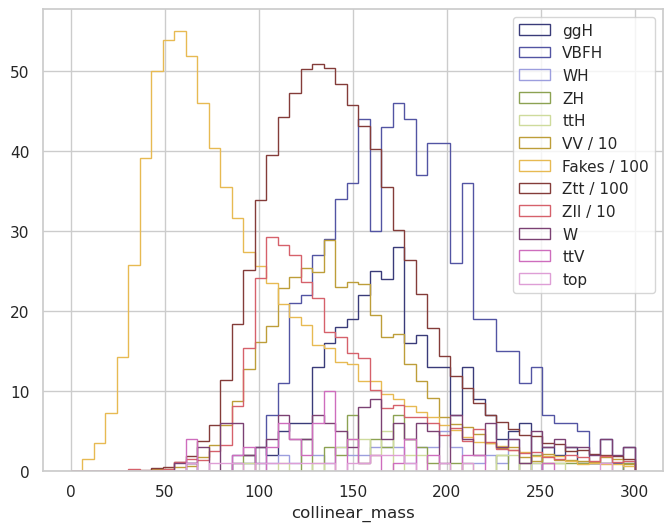

In [43]:
plt.figure(figsize=(8, 6))
plot_int = 'collinear_mass'
plt_bins = np.linspace(0, 300, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20b(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
plt.hist(ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
plt.hist(data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100', weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
plt.hist(ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
plt.hist(zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
plt.hist(w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
plt.xlabel(plot_int)
plt.show()

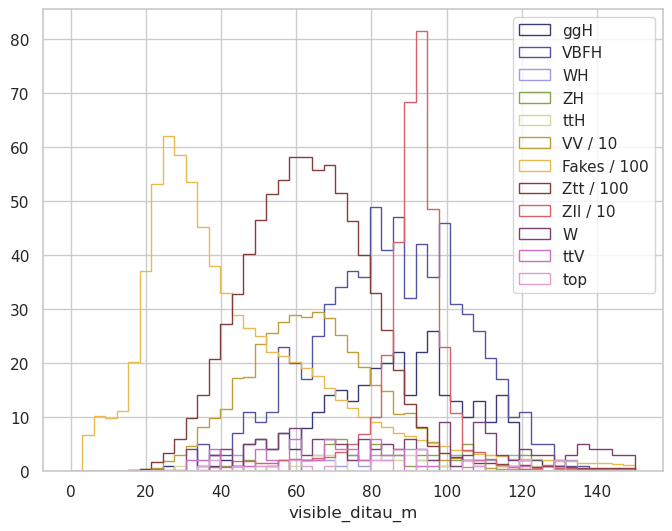

In [44]:
plt.figure(figsize=(8, 6))
plot_int = 'visible_ditau_m'
plt_bins = np.linspace(0, 150, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20b(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
plt.hist(ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
plt.hist(data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100', weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
plt.hist(ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
plt.hist(zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
plt.hist(w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
plt.xlabel(plot_int)
plt.show()

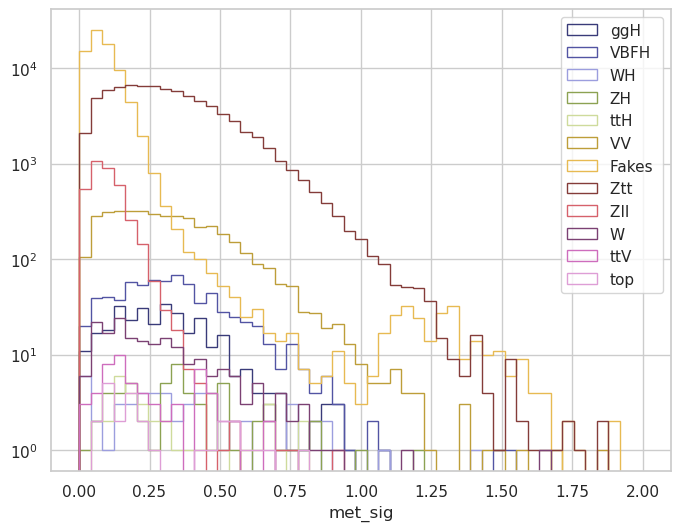

In [45]:
plt.figure(figsize=(8, 6))
plot_int = 'met_sig'
plt_bins = np.linspace(0, 2, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20b(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
plt.hist(ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV ', color=colors[5])
plt.hist(data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes ', color=colors[6])
plt.hist(ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt ', color=colors[7])
plt.hist(zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll ', color=colors[8])
plt.hist(w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
plt.yscale('log')
plt.xlabel(plot_int)
plt.show()

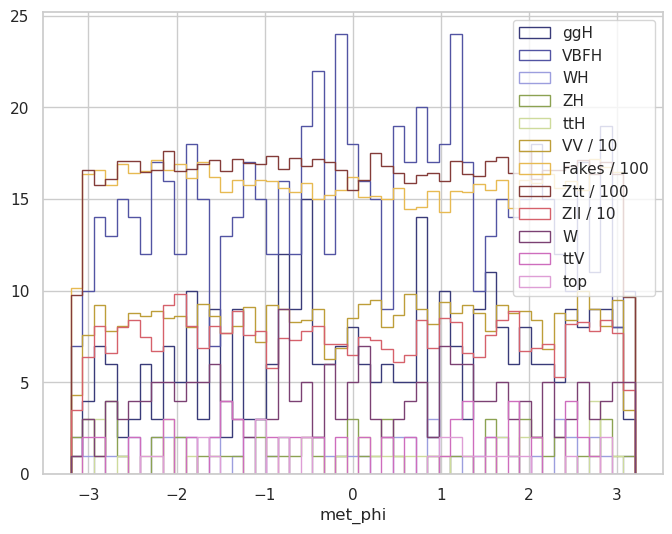

In [46]:
plt.figure(figsize=(8, 6))
plot_int = 'met_phi'
plt_bins = np.linspace(-3.2, 3.2, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20b(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
plt.hist(ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
plt.hist(data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100',  weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
plt.hist(ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
plt.hist(zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
plt.hist(w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
# plt.yscale('log')
plt.xlabel(plot_int)
plt.show()

Start Plot: leadsubjet_pT
Start Plot: subleadsubjet_pT
Start Plot: visible_ditau_m
Start Plot: met
Start Plot: k_t
Start Plot: kappa
Start Plot: delta_R
Start Plot: delta_phi
Start Plot: delta_eta


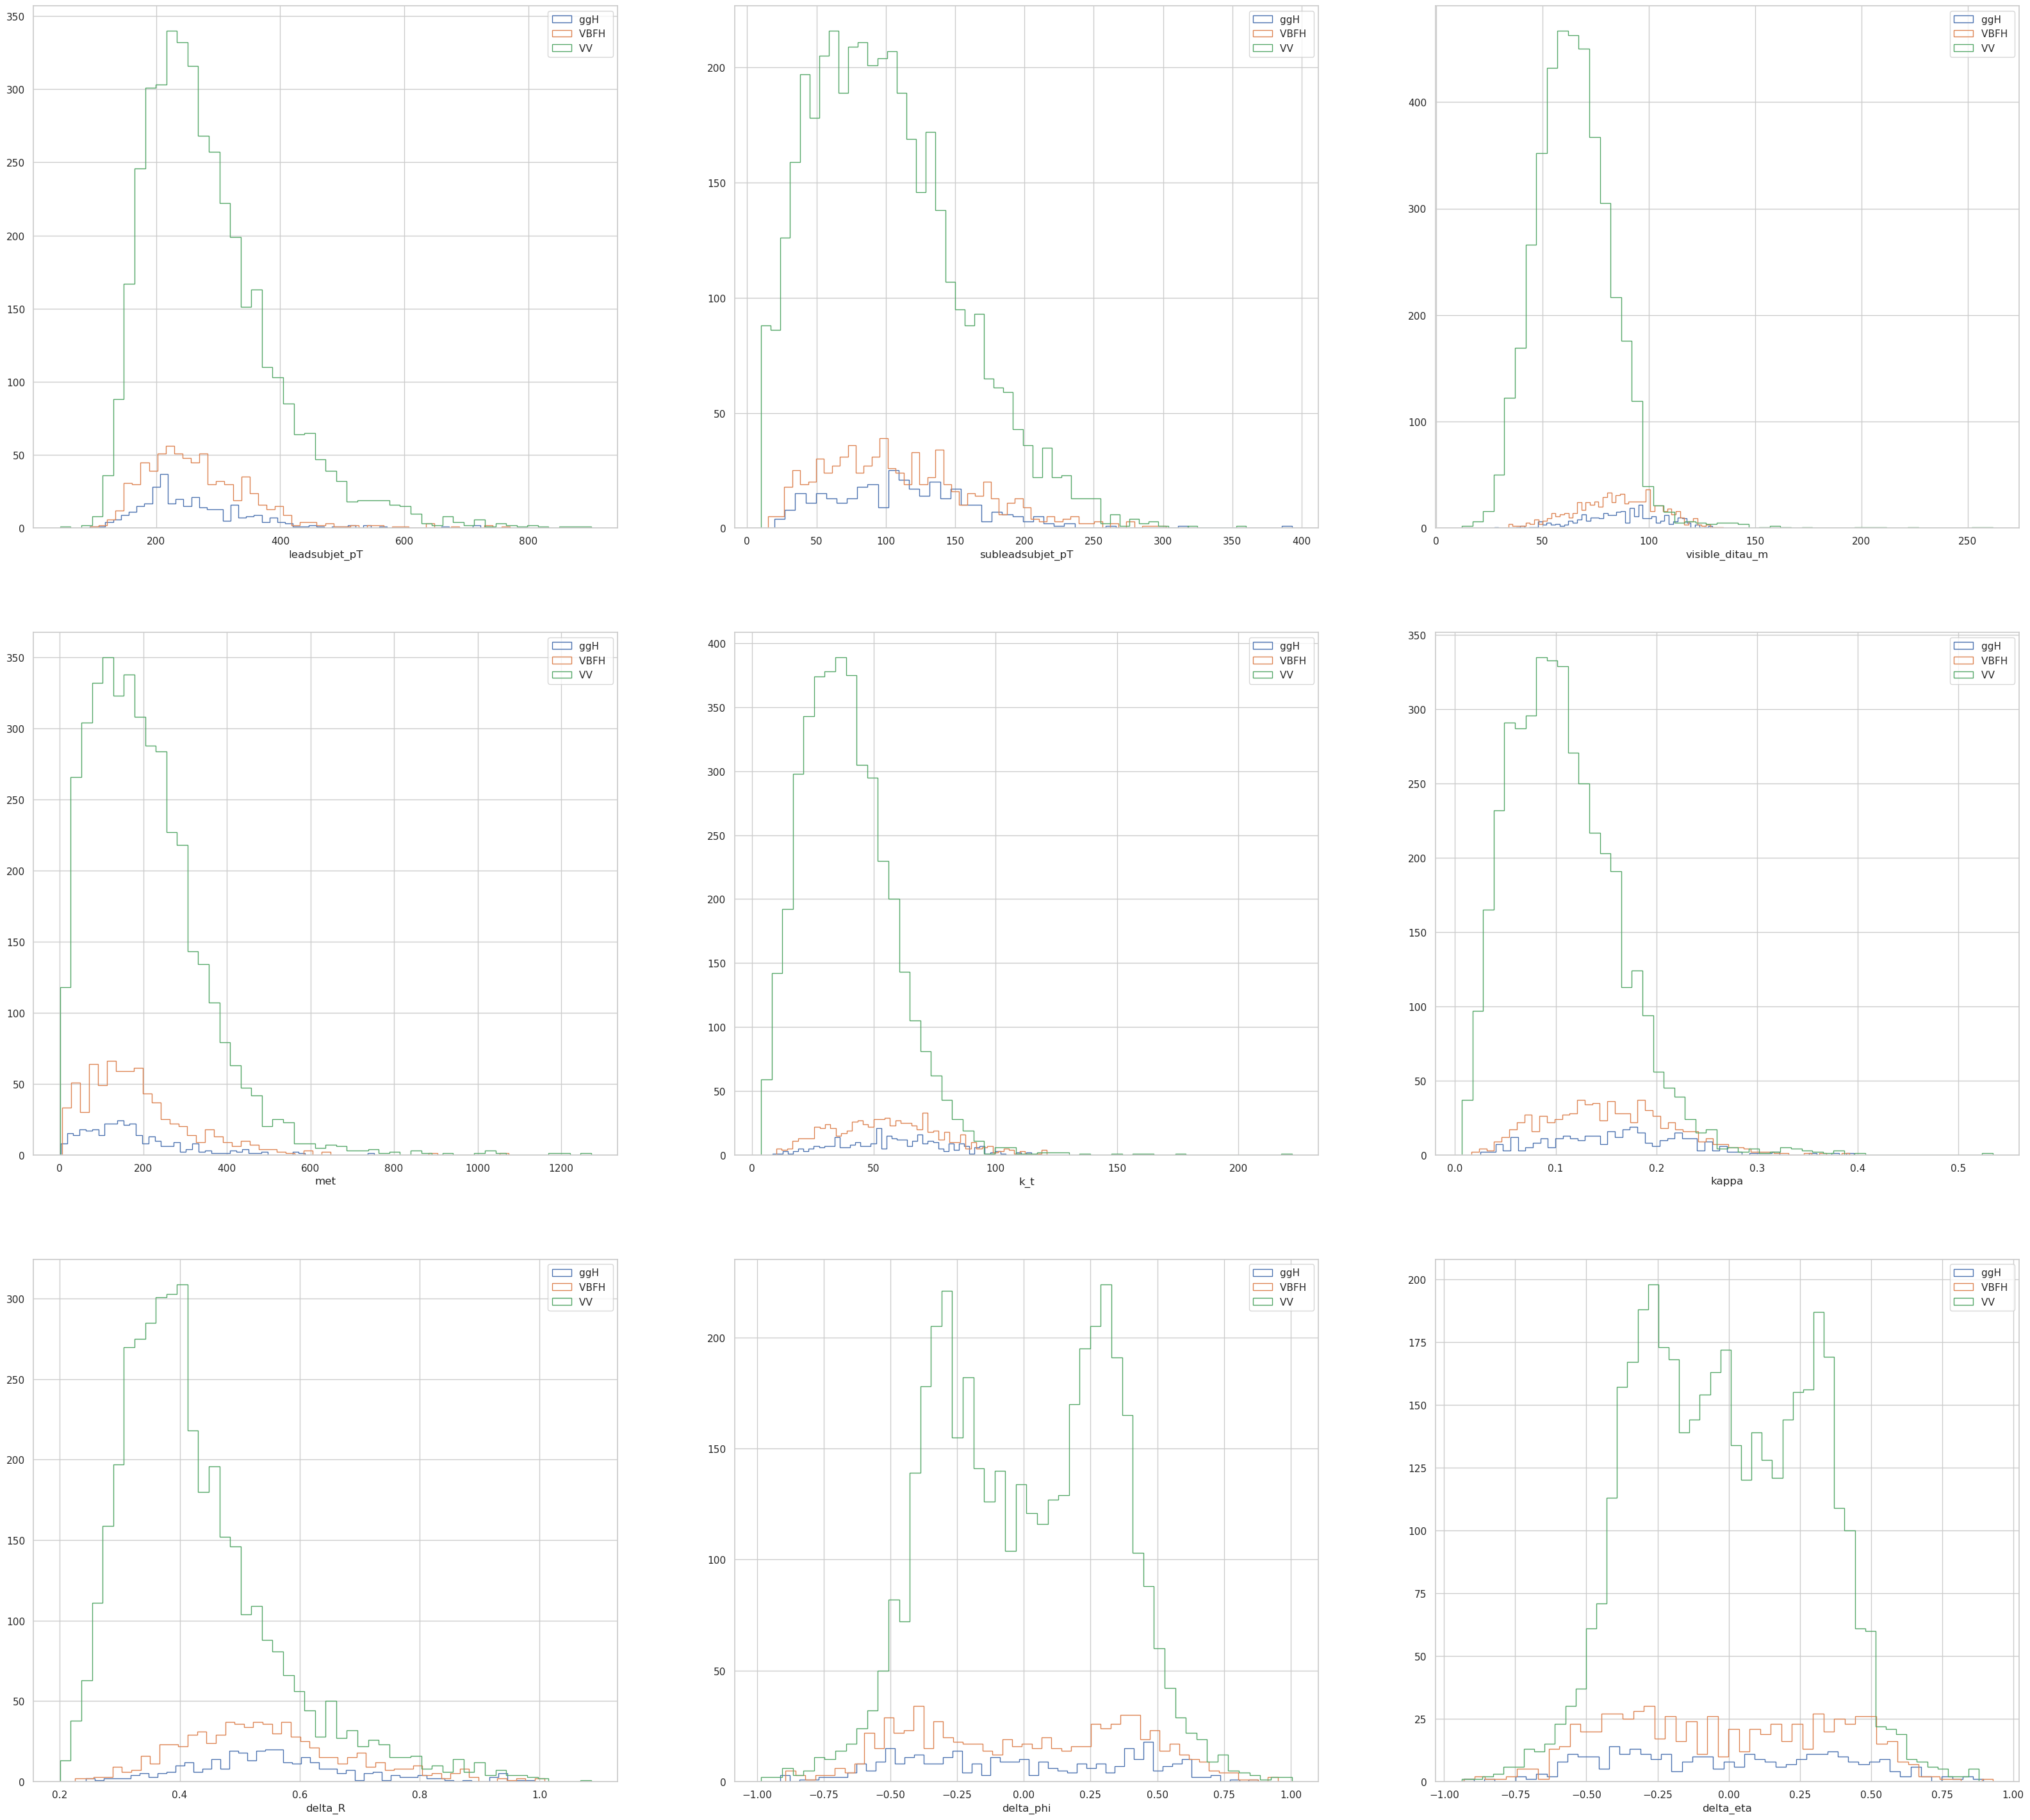

In [148]:
# plot_var = [
#     'leadsubjet_pT', 'subleadsubjet_pT',
#     'ditau_m', 'leadsubjet_eta', 'subleadsubjet_eta',
#     'leadsubjet_phi', 'subleadsubjet_phi'
# ]
plot_var = [
'leadsubjet_pT', 'subleadsubjet_pT', 'visible_ditau_m', 'met', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta'
]

plt.figure(figsize=(40, 36))
def hist(variable, plot_num):
    print("Start Plot:", variable)
    plt.subplot(3, 3, plot_num+1)
    bin = 50
    plt.hist(ggh_plot[variable], bins=bin, histtype='step', linewidth=1, label=f'ggH ')
    plt.hist(vbfh_plot[variable], bins=bin, histtype='step', linewidth=1, label=f'VBFH ')
    plt.hist(vv_plot[variable], bins=bin, histtype='step', linewidth=1, label=f'VV ')
    # plt.hist(ztt_plot[i], bins=bin, histtype='step', linewidth=1, label=f'Ztt ', weights=np.ones_like(ztt_plot[i])/10)
    plt.xlabel(variable)
    #plt.ylabel("Number of Events (scaled)")
    #plt.title(xlabel)
#     plt.yscale('log')
    plt.legend()
    plt.grid(True)

for i, label in enumerate(plot_var, 0):
    hist(label, i)

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


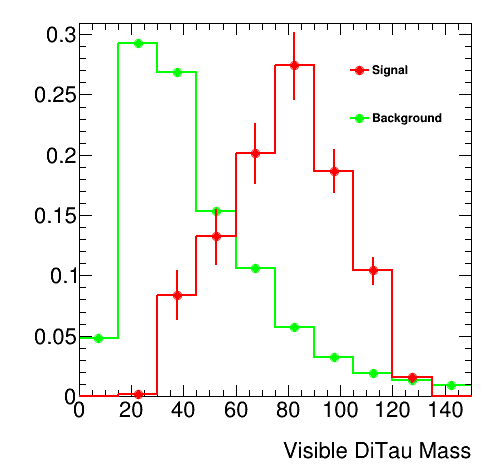

In [47]:
ROOT.gROOT.SetStyle("ATLAS")
canvas = ROOT.TCanvas("canvas", "eff_plots", 500, 500)
canvas.Clear()
canvas.cd()

# ggh_plt = plt_to_root_hist_w(ggh_plot[2], 10, 0, 150, None, False)
# ggh_plt.SetLineColor(ROOT.kRed)
# ggh_plt.SetMarkerColor(ROOT.kRed)
# vbfh_plt = plt_to_root_hist_w(vbfh_plot[2], 10, 0, 150, None, False)
# vbfh_plt.SetLineColor(ROOT.kBlue)
# vbfh_plt.SetMarkerColor(ROOT.kBlue)
# vv_plt = plt_to_root_hist_w(vv_plot[2], 10, 0, 150, None, False)
# vv_plt.SetLineColor(ROOT.kGreen)
# vv_plt.SetMarkerColor(ROOT.kGreen)
# ztt_plt = plt_to_root_hist_w(ztt_plot[2], 10, 0, 150, None, False)
# ztt_plt.SetLineColor(ROOT.kOrange)
# ztt_plt.SetMarkerColor(ROOT.kOrange)

#combine signal to one plot
all_signal = np.concatenate((ggh_plot['visible_ditau_m'], vbfh_plot['visible_ditau_m'], wh_plot['visible_ditau_m'], zh_plot['visible_ditau_m'], tth_plot['visible_ditau_m']))
all_signal_weights = np.concatenate((ggh_plot['combined_weights'], vbfh_plot['combined_weights'], wh_plot['combined_weights'], zh_plot['combined_weights'], tth_plot['combined_weights']))
all_signal = plt_to_root_hist_w(all_signal, 10, 0, 150, all_signal_weights, False)
all_signal.SetLineColor(ROOT.kRed)
all_signal.SetMarkerColor(ROOT.kRed)
all_signal.SetMarkerStyle(20)

#combine background to one plot
all_background = np.concatenate((vv_plot['visible_ditau_m'], ztt_plot['visible_ditau_m'], w_plot['visible_ditau_m'], top_plot['visible_ditau_m'], zll_plot['visible_ditau_m'], ttv_plot['visible_ditau_m'], data_plot['visible_ditau_m']))
all_background_weights = np.concatenate((vv_plot['combined_weights'], ztt_plot['combined_weights'], w_plot['combined_weights'], top_plot['combined_weights'], zll_plot['combined_weights'], ttv_plot['combined_weights'], np.ones_like(data_plot['visible_ditau_m'])))
all_background = plt_to_root_hist_w(all_background, 10, 0, 150, all_background_weights, False)
all_background.SetLineColor(ROOT.kGreen)
all_background.SetMarkerColor(ROOT.kGreen)
all_background.SetMarkerStyle(20)

# ggh_plt = plt_to_root_hist_w(ggh_plot['visible_ditau_m'], 20, 0, 150, ggh_plot['combined_weights']*lumi_scale_factor, False)
# ggh_plt.SetLineColor(ROOT.kBlue)
# ggh_plt.SetMarkerColor(ROOT.kBlue)
# ggh_plt.SetMarkerStyle(20)
# vbfh_plt = plt_to_root_hist_w(vbfh_plot['visible_ditau_m'], 20, 0, 150, vbfh_plot['combined_weights']*lumi_scale_factor, False)
# vbfh_plt.SetLineColor(ROOT.kRed)
# vbfh_plt.SetMarkerColor(ROOT.kRed)
# vbfh_plt.SetMarkerStyle(20)
# vh_plt = plt_to_root_hist_w(vh_plot['visible_ditau_m'], 20, 0, 150, vh_plot['combined_weights']*lumi_scale_factor, False)
# vh_plt.SetLineColor(ROOT.kYellow)
# vh_plt.SetMarkerColor(ROOT.kYellow)
# vh_plt.SetMarkerStyle(20)
# wh_plt = plt_to_root_hist_w(wh_plot['visible_ditau_m'], 20, 0, 150, wh_plot['combined_weights']*lumi_scale_factor, False)
# wh_plt.SetLineColor(ROOT.kGreen)
# wh_plt.SetMarkerColor(ROOT.kGreen)
# wh_plt.SetMarkerStyle(20)
# zh_plt = plt_to_root_hist_w(zh_plot['visible_ditau_m'], 20, 0, 150, zh_plot['combined_weights']*lumi_scale_factor, False)
# zh_plt.SetLineColor(ROOT.kOrange)
# zh_plt.SetMarkerColor(ROOT.kOrange)
# zh_plt.SetMarkerStyle(20)
# tth_plt = plt_to_root_hist_w(tth_plot['visible_ditau_m'], 20, 0, 150, tth_plot['combined_weights']*lumi_scale_factor, False)
# tth_plt.SetLineColor(ROOT.kMagenta)
# tth_plt.SetMarkerColor(ROOT.kMagenta)
# tth_plt.SetMarkerStyle(20)

# vv_plt = plt_to_root_hist_w(vv_plot['visible_ditau_m'], 20, 0, 150, vv_plot['combined_weights'], False)
# vv_plt.SetLineColor(ROOT.kGreen)
# vv_plt.SetMarkerColor(ROOT.kGreen)
# vv_plt.SetMarkerStyle(20)
# ztt_plt = plt_to_root_hist_w(ztt_plot['visible_ditau_m'], 20, 0, 150, ztt_plot['combined_weights'], False)
# ztt_plt.SetLineColor(ROOT.kOrange)
# ztt_plt.SetMarkerColor(ROOT.kOrange)
# ztt_plt.SetMarkerStyle(20)
# w_plt = plt_to_root_hist_w(W_plot['visible_ditau_m'], 20, 0, 150, W_plot['combined_weights'], False)
# w_plt.SetLineColor(ROOT.kBlack)
# w_plt.SetMarkerColor(ROOT.kBlack)
# w_plt.SetMarkerStyle(20)
# top_plt = plt_to_root_hist_w(Top_plot['visible_ditau_m'], 20, 0, 150, Top_plot['combined_weights'], False)
# top_plt.SetLineColor(ROOT.kGray)
# top_plt.SetMarkerColor(ROOT.kGray)
# top_plt.SetMarkerStyle(20)
# zll_inc_plt = plt_to_root_hist_w(Zll_inc_plot['visible_ditau_m'], 20, 0, 150, Zll_inc_plot['combined_weights'], False)
# zll_inc_plt.SetLineColor(ROOT.kCyan)
# zll_inc_plt.SetMarkerColor(ROOT.kCyan)
# zll_inc_plt.SetMarkerStyle(20)

# ggh_plt.Scale(1. / ggh_plt.Integral())
# vbfh_plt.Scale(1. / vbfh_plt.Integral())
# vv_plt.Scale(1. / vv_plt.Integral())
# ztt_plt.Scale(1. / ztt_plt.Integral())

# ztt_plt.Draw("hist e ")
# zll_inc_plt.Draw("hist e same")
# vv_plt.Draw("hist e same")
# top_plt.Draw("hist e same")
# w_plt.Draw("hist e same")
# vbfh_plt.Draw("hist e same")
# ggh_plt.Draw("hist e same")
# zh_plt.Draw("hist e same")
# wh_plt.Draw("hist e same")
# tth_plt.Draw("hist e same")
# vh_plt.Draw("hist e same")

all_background.Scale(1. / all_background.Integral())
all_signal.Scale(1. / all_signal.Integral())

all_background.Draw("hist e")
all_signal.Draw("hist e same")

all_background.GetXaxis().SetTitle('Visible DiTau Mass')

legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.SetBorderSize(0)
legend.SetFillColor(0)
# legend.AddEntry(ggh_plt, "ggH")
# legend.AddEntry(vbfh_plt, "VBFH")
# legend.AddEntry(vh_plt, "VH")
# legend.AddEntry(wh_plt, "WH")
# legend.AddEntry(zh_plt, "ZH")
# legend.AddEntry(tth_plt, "ttH")
# legend.AddEntry(vv_plt, "VV")
# legend.AddEntry(ztt_plt, "Ztt")
# legend.AddEntry(w_plt, "W")
# legend.AddEntry(top_plt, "Top")
# legend.AddEntry(zll_inc_plt, "Zll_inc")

legend.AddEntry(all_signal, "Signal")
legend.AddEntry(all_background, "Background")

legend.Draw()
canvas.Draw()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


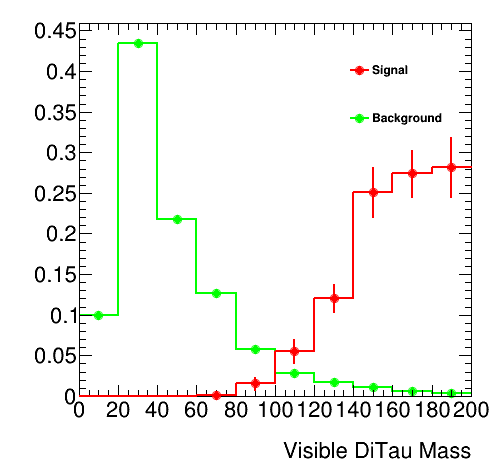

In [48]:
ROOT.gROOT.SetStyle("ATLAS")
canvas = ROOT.TCanvas("canvas", "eff_plots", 500, 500)
canvas.Clear()
canvas.cd()

#combine signal to one plot
all_signal = np.concatenate((ggh_plot['collinear_mass'], vbfh_plot['collinear_mass'], wh_plot['collinear_mass'], zh_plot['collinear_mass'], tth_plot['collinear_mass']))
all_signal_weights = np.concatenate((ggh_plot['combined_weights'], vbfh_plot['combined_weights'], wh_plot['combined_weights'], zh_plot['combined_weights'], tth_plot['combined_weights']))
all_signal = plt_to_root_hist_w(all_signal, 10, 0, 200, all_signal_weights, False)
all_signal.SetLineColor(ROOT.kRed)
all_signal.SetMarkerColor(ROOT.kRed)
all_signal.SetMarkerStyle(20)

#combine background to one plot
all_background = np.concatenate((vv_plot['collinear_mass'], ztt_plot['collinear_mass'], w_plot['collinear_mass'], top_plot['collinear_mass'], zll_plot['collinear_mass'], ttv_plot['collinear_mass'], data_plot['visible_ditau_m']))
all_background_weights = np.concatenate((vv_plot['combined_weights'], ztt_plot['combined_weights'], w_plot['combined_weights'], top_plot['combined_weights'], zll_plot['combined_weights'], ttv_plot['combined_weights'], np.ones_like(data_plot['visible_ditau_m'])))
all_background = plt_to_root_hist_w(all_background, 10, 0, 200, all_background_weights, False)
all_background.SetLineColor(ROOT.kGreen)
all_background.SetMarkerColor(ROOT.kGreen)
all_background.SetMarkerStyle(20)

all_background.Scale(1. / all_background.Integral())
all_signal.Scale(1. / all_signal.Integral())

all_background.Draw("hist e")
all_signal.Draw("hist e same")

all_background.GetXaxis().SetTitle('Visible DiTau Mass')

legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.SetBorderSize(0)
legend.SetFillColor(0)

legend.AddEntry(all_signal, "Signal")
legend.AddEntry(all_background, "Background")

legend.Draw()
canvas.Draw()


In [37]:
significance_bin_by_bin(all_signal, all_background, s_much_less_than_b=False)

bin 1, signal = 0.0, background = 8.20016220940925e-05, significance = 0.0
bin 2, signal = 0.0017468021758674792, background = 0.00815823624625029, significance = 0.018704512786431888
bin 3, signal = 0.08397145971508287, background = 0.0891899566475162, significance = 0.2486502756958589
bin 4, signal = 0.13241932044699628, background = 0.25475976938434286, significance = 0.24347817269002967
bin 5, signal = 0.2016101267300697, background = 0.28925166634725785, significance = 0.34055757639816436
bin 6, signal = 0.27409084344760953, background = 0.19369569169059267, significance = 0.5260563675997969
bin 7, signal = 0.1867293471259057, background = 0.08960336676925847, significance = 0.49895906240883603
bin 8, signal = 0.10410516746002246, background = 0.040103113882970366, significance = 0.4011315600716286
bin 9, signal = 0.015326932898446137, background = 0.023370703349727368, significance = 0.091521606336157
bin 10, signal = 0.0, background = 0.011785494059990005, significance = 0.0
bin

0.9656169440233111

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


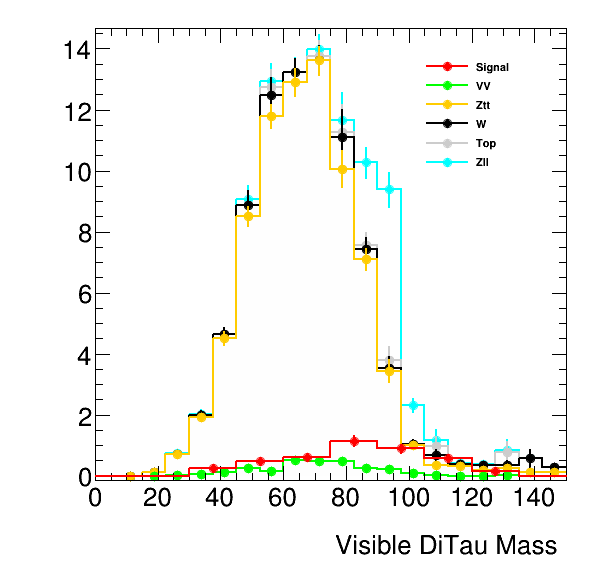

In [21]:
# make root fplot of all signal stracked together and all background stacked together
canvas = ROOT.TCanvas("canvas", "eff_plots", 600, 600)
canvas.Clear()
canvas.cd()

#stacked signal
# stacked_signal = ROOT.THStack("stacked_signal", "stacked_signal")
# stacked_signal.Add(ggh_plt)
# stacked_signal.Add(vbfh_plt)
# stacked_signal.Add(vh_plt)
# stacked_signal.Add(wh_plt)
# stacked_signal.Add(zh_plt)
# stacked_signal.Add(tth_plt)

#stacked background
stacked_background = ROOT.THStack("stacked_background", "stacked_background")
stacked_background.Add(vv_plt)
stacked_background.Add(ztt_plt)
stacked_background.Add(w_plt)
stacked_background.Add(top_plt)
stacked_background.Add(zll_inc_plt)

stacked_background.Draw("hist e")
all_signal.Draw("hist e same")

stacked_background.GetXaxis().SetTitle('Visible DiTau Mass')

legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.SetBorderSize(0)
legend.SetFillColor(0)
# legend.AddEntry(ggh_plt, "ggH")
# legend.AddEntry(vbfh_plt, "VBFH")
# legend.AddEntry(vh_plt, "VH")
# legend.AddEntry(wh_plt, "WH")
# legend.AddEntry(zh_plt, "ZH")
# legend.AddEntry(tth_plt, "ttH")
legend.AddEntry(all_signal, "Signal")
legend.AddEntry(vv_plt, "VV")
legend.AddEntry(ztt_plt, "Ztt")
legend.AddEntry(w_plt, "W")
legend.AddEntry(top_plt, "Top")
legend.AddEntry(zll_inc_plt, "Zll")
#make legend text size bigger
legend.SetTextSize(0.02)
#sapce out the markers in the legend
legend.SetMargin(0.5)
#sepreate markers in the legend
legend.SetEntrySeparation(0.1)


legend.Draw()

canvas.Draw()


In [49]:
import logging

def bin_significance_counting(signal, bkg, s_much_less_than_b=True):
    """
    Helper function to compute significance in a given bin
    Given by the following formula:

    Z = sqrt(2 * ((s + b) * log(1 + s / b) - s))
    """
    if s_much_less_than_b:
        return signal / np.sqrt(bkg)
    else:
        sig = (signal + bkg) * np.log(1 + signal / bkg) - signal
        sig = np.sqrt(2 * sig)
        return sig

def significance_bin_by_bin(signal, bkg, s_much_less_than_b=True):
    """
    Calculate total significance using bin-by-bin significance
    via a simple sum in quadrature of each bin significance
    """

    tot_signifiance = 0
    for iBin, (s, b) in enumerate(zip(signal, bkg)):
        if b <= 0:
            continue
        _sig = bin_significance_counting(s, b, s_much_less_than_b=s_much_less_than_b)
        print(
            'bin {}, signal = {}, background = {}, significance = {}'.format(
            iBin, s, b, _sig))
        tot_signifiance += _sig * _sig

    return np.sqrt(tot_signifiance)

In [53]:
vbfh_plot['label'] = 1
ggh_plot['label'] = 1
wh_plot['label'] = 1
zh_plot['label'] = 1
tth_plot['label'] = 1

vv_plot['label'] = 0
top_plot['label'] = 0
ztt_plot['label'] = 0
ttv_plot['label'] = 0
w_plot['label'] = 0
zll_plot['label'] = 0

data_plot['label'] = 0

df = pd.concat([data_plot, ggh_plot, vbfh_plot, wh_plot, zh_plot, tth_plot, vv_plot, top_plot, ztt_plot, ttv_plot, w_plot, zll_plot])
# training_var = [
#     'leadsubjet_pT', 'subleadsubjet_pT',
#     'visible_ditau_m', 'k_t', 'delta_R', 'combined_weights', 'label'
# ]
training_var = [
    'leadsubjet_pT', 'subleadsubjet_pT',
    'collinear_mass', 'delta_R', 'delta_phi', 'delta_eta', 'label', 'met', 'met_sig', 'event_number'
]

df = df[training_var]

# df['delta_R'] = np.log(1/df['delta_R'])
# df['k_t'] = np.log(df['k_t'])
# df['met'] =  np.log(df['met'])

#drop weight column
# df = df.drop(columns=['combined_weights'])
df

,leadsubjet_pT,subleadsubjet_pT,collinear_mass,delta_R,delta_phi,delta_eta,label,met,met_sig,event_number
0,454.704156,25.682889,58.865481,0.237291,-0.075515,0.224954,0,44.850841,0.004946,480494748.0
1,198.666297,25.295963,78.891129,0.396763,-0.110227,-0.381144,0,94.716884,0.171346,499095610.0
2,413.315250,24.097494,44.098526,0.353011,-0.125690,0.329877,0,8.423738,0.030742,504447465.0
3,197.924266,138.791734,155.353263,0.605507,-0.232417,-0.559125,0,79.224896,0.094597,504982228.0
4,379.306719,12.539335,186.997565,0.973038,-0.244397,-0.941845,0,64.431604,0.082266,506132307.0
...,...,...,...,...,...,...,...,...,...,...
3611,166.412984,35.463879,267.337626,0.744402,0.429683,-0.607870,0,260.223681,0.088671,1807282.0
3612,304.389219,85.817539,111.546834,0.606632,-0.605777,-0.032204,0,21.026610,0.040057,1282808.0
3613,294.523906,125.229352,107.062062,0.478557,0.477953,0.024029,0,30.418938,0.068171,1394821.0
3614,448.864500,119.532711,91.130893,0.329578,0.197532,0.263823,0,35.597672,0.135856,1619938.0


In [54]:
#check how many rows there are with label 1 and 0
df['label'].value_counts()

label
0    164854
1      1191
Name: count, dtype: int64

In [74]:
def split_data(df):
    # Split data based on event number
    ids = df['event_number'] % 5
    #append ids to the dataframe
    df['ids'] = ids
    print("Data Split:", len(df[ids == 0]), len(df[ids == 1]), len(df[ids == 2]), len(df[ids == 3]), len(df[ids == 4]))
    #print how many signal and background events are in each set
    print("Signal Split:", len(df[(df['label'] == 1) & (df['ids'] == 0)]), len(df[(df['label'] == 1) & (df['ids'] == 1)]), len(df[(df['label'] == 1) & (df['ids'] == 2)]), len(df[(df['label'] == 1) & (df['ids'] == 3)]), len(df[(df['label'] == 1) & (df['ids'] == 4)]))
    print("Background Split:", len(df[(df['label'] == 0) & (df['ids'] == 0)]), len(df[(df['label'] == 0) & (df['ids'] == 1)]), len(df[(df['label'] == 0) & (df['ids'] == 2)]), len(df[(df['label'] == 0) & (df['ids'] == 3)]), len(df[(df['label'] == 0) & (df['ids'] == 4)]))
    return [df[ids == 0], df[ids == 1], df[ids == 2], df[ids == 3], df[ids == 4]]
    # return [df[ids == 0], df[ids == 1], df[ids == 2]]

Data Split: 33411 33176 33369 33133 32956
Signal Split: 246 210 236 232 267
Background Split: 33165 32966 33133 32901 32689
len X_train: 132634
len X_test: 33411
signal scaling factor:  139.35343915343915
len X_train: 132869
len X_test: 33176
signal scaling factor:  134.44240570846077
len X_train: 132676
len X_test: 33369
signal scaling factor:  137.92774869109948
len X_train: 132912
len X_test: 33133
signal scaling factor:  137.59436913451512
len X_train: 133089
len X_test: 32956
signal scaling factor:  143.03571428571428


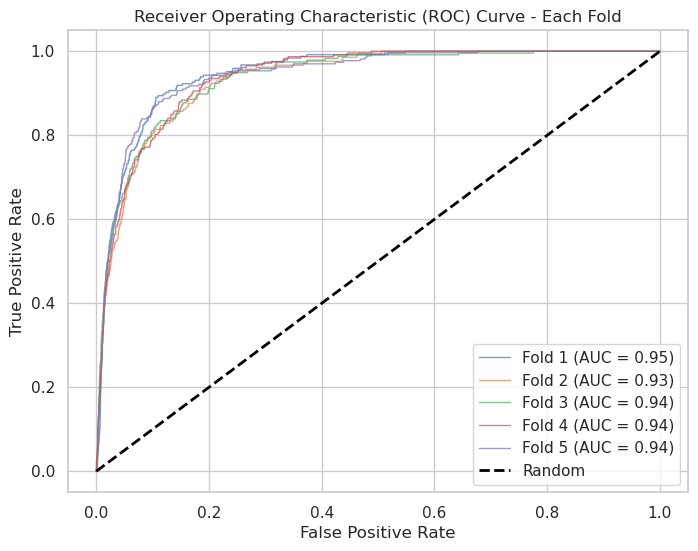

In [75]:
#split the data into 5 sets
df_split = split_data(df)
models = []
signal_scores = []
background_scores = []


# training_var = ['f0', 'f1', 'f2', 'f3', 'f4']
# feature_name_mapping = {
#     'leadsubjet_pT': 'f0',
#     'subleadsubjet_pT': 'f1',
#     'visible_ditau_m': 'f2',
#     'delta_R': 'f3',
#     'met': 'f4',
#     'label': 'label',
#     'ids': 'ids',
#     'event_number': 'event_number',
#     'delta_phi': 'delta_phi',
#     'delta_eta': 'delta_eta',
# }
training_var = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5']
feature_name_mapping = {
    'leadsubjet_pT': 'f0',
    'subleadsubjet_pT': 'f1',
    'collinear_mass': 'f2',
    'delta_R': 'f3',
    'met': 'f4',
    'met_sig': 'f5',
    'label': 'label',
    'ids': 'ids',
    'event_number': 'event_number',
    'delta_phi': 'delta_phi',
    'delta_eta': 'delta_eta',
}

#map df_split cloumn names 
for i in range(len(df_split)):
    df_split[i] = df_split[i].rename(columns=feature_name_mapping)

# print(df_split[0])
plt.figure(figsize=(8, 6))

for i in range(len(df_split)):

    X_test = df_split[i][training_var]
    y_test  = df_split[i]['label']

    X_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])[training_var]
    y_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['label']

    print("len X_train:", len(X_train))
    print("len X_test:", len(X_test))

    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    print("signal scaling factor: ", scale_pos_weight)
    params = {
    'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50,
    'eval_metric': 'logloss',
    'random_state': 2,
    'scale_pos_weight': scale_pos_weight,
    'base_score': 0.5,
    'objective':'binary:logistic', 
    'gamma': 0.001,
    'verbosity': 1
    }
    model = XGBClassifier(**params)
    # Train the model
    model.fit(X_train, y_train)
    models.append(model)
    booster = model.get_booster()
    booster.dump_model('xgboost_k_fold_model_{}.txt'.format(i))

    # Predict probabilities for the test set
    y_pred_proba = model.predict_proba(X_test)
    # Extract scores for signal and background
    signal_scores.extend(y_pred_proba[:, 1][y_test == 1])
    background_scores.extend(y_pred_proba[:, 1][y_test == 0])

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.7, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=2, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Each Fold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



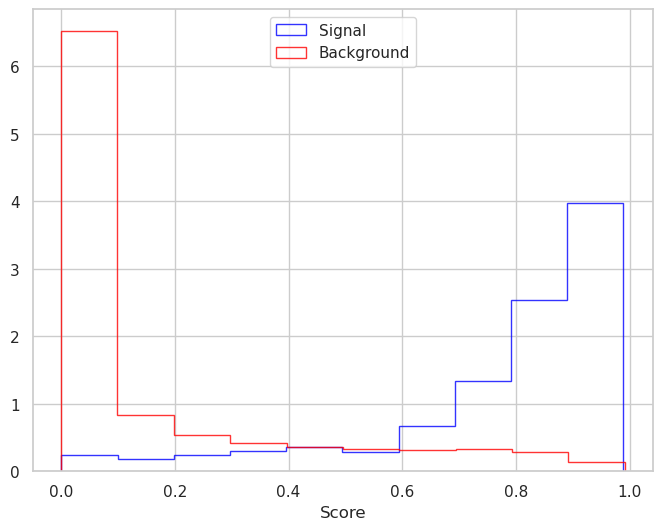

In [76]:
plt.figure(figsize=(8, 6))
plt.hist(signal_scores, bins=10, alpha=0.8, color='blue', label='Signal', histtype='step', density=True)
plt.hist(background_scores, bins=10, alpha=0.8, color='red', label='Background', histtype='step', density=True)
plt.xlabel('Score')
# plt.yscale('log')
plt.legend(loc='upper center')
plt.grid(True)
plt.show()

In [62]:
# # Initialize k-fold cross-validation
# # kf = KFold(n_splits=5, shuffle=True, random_state=42)
# kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# # Initialize lists to store scores
# signal_scores = []
# background_scores = []
# proba_and_values = []
# models = []

# training_var = [
#     'leadsubjet_pT', 'subleadsubjet_pT',
#     'visible_ditau_m', 'delta_R', 'met', 'label'
# ]
# X = df[training_var[:-1]]  # Features
# print(X.columns)
# y = df['label']  # Target variable

# scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
# print(scale_pos_weight)
# plt.figure(figsize=(8, 6))

# # Iterate through each fold
# # for train_index, test_index in kf.split(X):
# for i, (train_index, test_index) in enumerate(kf.split(X, y)):
#     # Split train and test sets
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     #change column names to f1, f2, f3, f4, f5
#     X_train.columns = ['f0', 'f1', 'f2', 'f3', 'f4']
#     X_test.columns = ['f0', 'f1', 'f2', 'f3', 'f4']
    
#     params = {
#     'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50,
#     'eval_metric': 'logloss',
#     'random_state': 2,
#     'scale_pos_weight': scale_pos_weight,
#     'base_score': 0.5,
#     # 'base_score': 1.e-9,
#     # 'max_delta_step': 3,
#     'objective':'binary:logistic', 
#     # 'num_class': 1,
#     'gamma': 0.001,
#     'verbosity': 1
#     }
#     model = XGBClassifier(**params)
#     # Train the model
#     model.fit(X_train, y_train)
#     models.append(model)

#     # Predict probabilities for the test set
#     y_pred_proba = model.predict_proba(X_test)
#     # Extract scores for signal and background
#     signal_scores.extend(y_pred_proba[:, 1][y_test == 1])
#     background_scores.extend(y_pred_proba[:, 1][y_test == 0])

#     # save the proba correspoending to the X_test values
#     proba_and_values.append((y_pred_proba, X_test))

#     fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, lw=1, alpha=0.7, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')


# plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=2, label='Random')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve - Each Fold')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()


In [109]:
# from sklearn.model_selection import cross_val_predict

# params = {
#     'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100,
#     'eval_metric': 'logloss',
#     'random_state': 2,
#     'scale_pos_weight': scale_pos_weight,
#     'base_score': 0.5,
#     # 'base_score': 1.e-9,
#     # 'max_delta_step': 3,
#     'objective':'binary:logistic', 
#     # 'num_class': 1,
#     'gamma': 0.001,
#     'verbosity': 1
#     }
# model_n = XGBClassifier(**params)

# # Perform cross-validation predictions
# y_pred_proba_cv = cross_val_predict(model_n, X, y, cv=5, method='predict_proba')

# # Get the predicted probabilities for the positive class
# positive_class_proba = y_pred_proba_cv[:, 1]


In [110]:
# plt.figure(figsize=(8, 6))
# plt.hist(positive_class_proba[y == 1], bins=10, alpha=0.8, color='blue', label='Signal', histtype='step', density=True)
# plt.hist(positive_class_proba[y == 0], bins=10, alpha=0.8, color='red', label='Background', histtype='step', density=True)
# plt.xlabel('Score')
# # plt.yscale('log')
# plt.legend(loc='upper center')
# plt.grid(True)
# plt.show()

# sig_hist = plt_to_root_hist_w(positive_class_proba[y == 1], 10, 0., 1., None, False)
# bkg_hist = plt_to_root_hist_w(positive_class_proba[y == 0], 10, 0., 1., None, False)
# sig_hist.Scale(1/sig_hist.Integral())
# bkg_hist.Scale(1/bkg_hist.Integral())
# significance_bin_by_bin(sig_hist, bkg_hist, s_much_less_than_b=False) ###0.99 with False

In [72]:
import xgboost as xgb
def get_basescore(model: xgb.XGBModel) -> float:
    import json

    """Get base score from an XGBoost sklearn estimator."""
    base_score = float(json.loads(model.get_booster().save_config())["learner"]["learner_model_param"]["base_score"])
    return base_score

print(get_basescore(model)) # usually 0.5

0.5


In [116]:
#split the data into training and testing
training_var_s = [
    'leadsubjet_pT', 'subleadsubjet_pT',
    'visible_ditau_m', 'delta_R', 'met'
]
X = df[training_var_s]

#log met, k_t
# X['k_t'] = np.log(X['k_t'])
# X['met'] =  np.log(X['met'])

y = df['label']
X.columns = ['f0', 'f1', 'f2', 'f3', 'f4']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

print(X_train.shape)
print(X_test.shape)

print(X_test)


(358120, 5)
(119374, 5)
                f0          f1         f2        f3          f4
49847   259.570422   17.771928  32.934955  0.431278   38.981745
57515   547.215438   43.986902  40.994083  0.214097   57.046170
274073  238.250812   98.409203  63.896306  0.411723  149.342770
249339  434.841844   27.389598  77.177209  0.692970   22.112775
235040  357.089938  118.947805  53.108746  0.256954  134.757983
...            ...         ...        ...       ...         ...
295758  401.401750  119.462250  56.586577  0.257545  230.461236
307449  285.513813   52.561375  51.801113  0.418755   68.092060
28834   299.563844  117.405375  93.561977  0.501867  156.257872
24884   348.954125   19.287604  19.555515  0.200935   40.304636
16625   152.645531  117.773414  67.321428  0.501127  148.387223

[119374 rows x 5 columns]


In [115]:
# # Load the XGBoost model
# trained_model = XGBClassifier()
# trained_model.load_model('xgboost_k_fold_model_v05.bin')

# # calucalte score values with X_train
# y_pred_proba_now = trained_model.predict_proba(X)

# k_fold_y_pred_proba_signal = y_pred_proba_now[:, 1][y == 1]
# k_fold_y_pred_proba_background = y_pred_proba_now[:, 1][y == 0]

In [113]:
#test k-fold model 
k_fold_y_pred_proba = model.predict_proba(X)
print(k_fold_y_pred_proba)
k_fold_y_pred_proba_signal = k_fold_y_pred_proba[:, 1][y == 1]
k_fold_y_pred_proba_background = k_fold_y_pred_proba[:, 1][y == 0]

[[0.7574674  0.2425326 ]
 [0.7418656  0.25813442]
 [0.9590607  0.04093928]
 ...
 [0.93259573 0.06740428]
 [0.83091724 0.16908276]
 [0.70026404 0.29973596]]


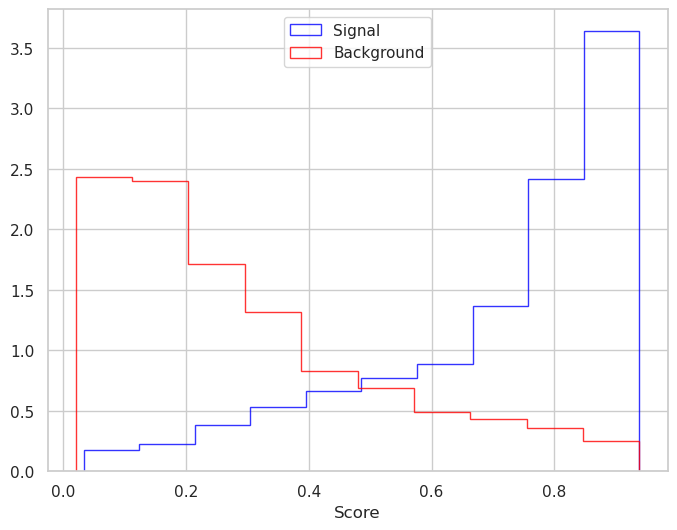

In [114]:
plt.figure(figsize=(8, 6))
plt.hist(k_fold_y_pred_proba_signal, bins=10, alpha=0.8, color='blue', label='Signal', histtype='step', density=True)
plt.hist(k_fold_y_pred_proba_background, bins=10, alpha=0.8, color='red', label='Background', histtype='step', density=True)
plt.xlabel('Score')
# plt.yscale('log')
plt.legend(loc='upper center')
plt.grid(True)
plt.show()

In [105]:
sig_hist = plt_to_root_hist_w(k_fold_y_pred_proba_signal, 10, 0., 1., None, False)
bkg_hist = plt_to_root_hist_w(k_fold_y_pred_proba_background, 10, 0., 1., None, False)
# sig_hist.Scale(all_signal.Integral()/sig_hist.Integral())
# bkg_hist.Scale(all_background.Integral()/bkg_hist.Integral())
sig_hist.Scale(1/sig_hist.Integral())
bkg_hist.Scale(1/bkg_hist.Integral())
significance_bin_by_bin(sig_hist, bkg_hist, s_much_less_than_b=False) ###0.99 with False

bin 1, signal = 0.011419249592169658, background = 0.1933377429982481, significance = 0.02572087770397132
bin 2, signal = 0.02027499417385225, background = 0.2401823318956135, significance = 0.04080796357620869
bin 3, signal = 0.037986483337217436, background = 0.17323220689640598, significance = 0.08820395860733088
bin 4, signal = 0.052901421580051275, background = 0.12563107165423718, significance = 0.14027578247194902
bin 5, signal = 0.06735026800279656, background = 0.07951555674837227, significance = 0.21336220652273147
bin 6, signal = 0.08063388487532044, background = 0.06365344260285755, significance = 0.27365714241302647
bin 7, signal = 0.09554882311815428, background = 0.04540757349382823, significance = 0.35811336907980823
bin 8, signal = 0.1689582847821021, background = 0.03994691496038698, significance = 0.5943730628580441
bin 9, signal = 0.30715450943835937, background = 0.031569960460943826, significance = 0.9966265159532022
bin 10, signal = 0.1577720810999767, background

1.5267220075310994

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [106]:
%jsroot on
ROOT.gROOT.SetStyle("ATLAS")

# plot sig_hist and bkg_hist
canvas = ROOT.TCanvas("canvas", "eff_plots", 600, 600)
canvas.Clear()
canvas.cd()

#plot signal
sig_hist.SetLineColor(ROOT.kRed)
sig_hist.SetMarkerColor(ROOT.kRed)
sig_hist.SetMarkerStyle(20)
#plot background
bkg_hist.SetLineColor(ROOT.kBlue)
bkg_hist.SetMarkerColor(ROOT.kBlue)
bkg_hist.SetMarkerStyle(20)

#set y axis range 
# bkg_hist.GetYaxis().SetRangeUser(0, 0.42)

sig_hist.Draw("hist e")
bkg_hist.Draw("hist e same")

sig_hist.GetXaxis().SetTitle('Score')

legend = ROOT.TLegend(0.3, 0.7, 0.6, 0.6)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.AddEntry(sig_hist, "Signal")
legend.AddEntry(bkg_hist, "Background")


legend.Draw()

canvas.Draw()



Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


In [66]:
#split the data into training and testing
training_var_s = [
    'leadsubjet_pT', 'subleadsubjet_pT',
    'visible_ditau_m', 'delta_R'
]
X = df[training_var_s]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

print(X_train)
#save weights in a separate variable
# weights_train = np.abs(X_train['combined_weights']*lumi_scale_factor)
# weights_test = np.abs(X_test['combined_weights']*lumi_scale_factor)

# weights should not be included in the training data
# X_train.drop(columns='combined_weights', inplace=True)
# X_test.drop(columns='combined_weights', inplace=True)

#Change column names to integers if needed (for ML models that expect numerical feature names)
# feature_mapping = {feature: i for i, feature in enumerate(X_train.columns)}
# X_train.rename(columns=feature_mapping, inplace=True)
# X_test.rename(columns=feature_mapping, inplace=True)

# istead of integers call the vaibels f1, f2, f3, f4
X_train.columns = ['f0', 'f1', 'f2', 'f3']
X_test.columns = ['f0', 'f1', 'f2', 'f3']
print(X_train.shape)
print(X_test.shape)

#print size of training and testing data
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, weights_train.shape, weights_test.shape)
print(X_train)


       leadsubjet_pT  subleadsubjet_pT  visible_ditau_m   delta_R
695       168.839000        148.980969        76.423859  0.484322
5107      250.002484         35.649836        81.025337  0.829278
9869      401.955562         70.824062        67.223823  0.393392
9552      287.338500        159.595281        76.977083  0.356377
27129     482.445500         74.760172        59.726687  0.313175
...              ...               ...              ...       ...
23508     203.900094        136.594797        66.182338  0.386745
8311      198.804250        124.709586        70.352782  0.445769
25736     166.437984        111.858586        38.559208  0.281043
2534      478.111938         53.083520        77.245657  0.488003
22248     310.281750         61.476922        65.366060  0.446063

[23671 rows x 4 columns]
(23671, 4)
(7891, 4)
               f0          f1         f2        f3
695    168.839000  148.980969  76.423859  0.484322
5107   250.002484   35.649836  81.025337  0.829278
9869   4

In [67]:
np.sum(y_test == 1)

116

In [107]:
# create the BDT
params = {
    'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100,
    'eval_metric': 'logloss',
    'random_state': 2,
    'scale_pos_weight': scale_pos_weight,
    'base_score': 0.5,
    'gamma': 0.001,
    'verbosity': 1
    }
bdt = XGBClassifier(**params)

# Train the classifier
# bdt.fit(X_train, y_train, eval_set=[(X_test, y_test)], sample_weight=weights_train)
bdt.fit(X_train, y_train, eval_set=[(X_test, y_test)])


[0]	validation_0-logloss:0.69010
[1]	validation_0-logloss:0.68712
[2]	validation_0-logloss:0.68420
[3]	validation_0-logloss:0.68140
[4]	validation_0-logloss:0.67861
[5]	validation_0-logloss:0.67599
[6]	validation_0-logloss:0.67340
[7]	validation_0-logloss:0.67074
[8]	validation_0-logloss:0.66826
[9]	validation_0-logloss:0.66583
[10]	validation_0-logloss:0.66335
[11]	validation_0-logloss:0.66084
[12]	validation_0-logloss:0.65816
[13]	validation_0-logloss:0.65587
[14]	validation_0-logloss:0.65365
[15]	validation_0-logloss:0.65136
[16]	validation_0-logloss:0.64917
[17]	validation_0-logloss:0.64671
[18]	validation_0-logloss:0.64446
[19]	validation_0-logloss:0.64238
[20]	validation_0-logloss:0.64036
[21]	validation_0-logloss:0.63825
[22]	validation_0-logloss:0.63594
[23]	validation_0-logloss:0.63399
[24]	validation_0-logloss:0.63170
[25]	validation_0-logloss:0.62982
[26]	validation_0-logloss:0.62799
[27]	validation_0-logloss:0.62606
[28]	validation_0-logloss:0.62412
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.001, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=2, ...)

In [78]:
model_dump = bdt.get_booster().get_dump(dump_format='json')
def predict_tree(tree, inst):
    if 'children' in tree:
        feature_id = tree['split']
        threshold = tree['split_condition']
        # default direction for missing value
        default_left = (tree['missing'] == tree['yes'])
        if feature_id not in inst:  # missing value
            return predict_tree(tree['children'][0 if default_left else 1], inst)
        elif inst[feature_id] < threshold:  # test is true, go to left child
            return predict_tree(tree['children'][0], inst)
        else:   # test is false, go to right child
            return predict_tree(tree['children'][1], inst)
    else:
        return tree['leaf']
def predict(model_dump, inst):
    return np.sum([predict_tree(json.loads(model_dump[i]), inst) for i in range(len(model_dump))])
def proba(model_dump, inst):
    val = predict(model_dump, inst)
    return (1.0 / (1.0 + np.exp(-val)))
proba(model_dump, {'f0': 229.442516, 'f1': 48.253684, 'f2': 53.500902, 'f3': 0.486874})

0.4480576537202827

                f0          f1         f2        f3          f4
49847   259.570422   17.771928  32.934955  0.431278   38.981745
57515   547.215438   43.986902  40.994083  0.214097   57.046170
274073  238.250812   98.409203  63.896306  0.411723  149.342770
249339  434.841844   27.389598  77.177209  0.692970   22.112775
235040  357.089938  118.947805  53.108746  0.256954  134.757983
...            ...         ...        ...       ...         ...
295758  401.401750  119.462250  56.586577  0.257545  230.461236
307449  285.513813   52.561375  51.801113  0.418755   68.092060
28834   299.563844  117.405375  93.561977  0.501867  156.257872
24884   348.954125   19.287604  19.555515  0.200935   40.304636
16625   152.645531  117.773414  67.321428  0.501127  148.387223

[119374 rows x 5 columns]
[0.22899197 0.22157636 0.30430833 ... 0.6807933  0.22157636 0.4464507 ]


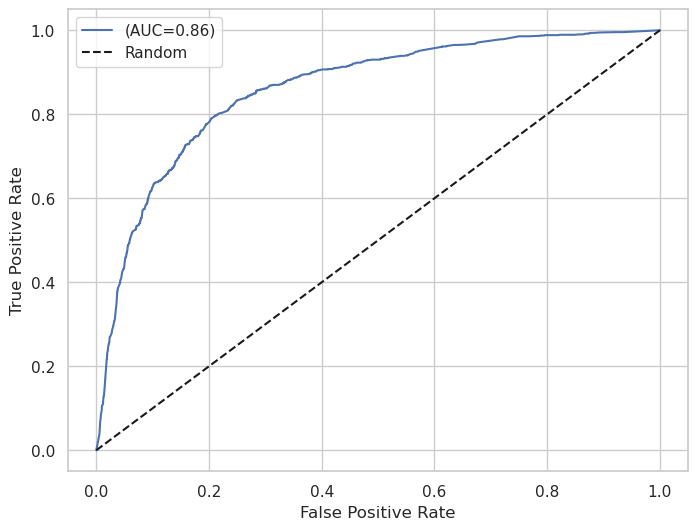

/tmp/ipykernel_248281/682549564.py:22: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1/fpr, lw=1)


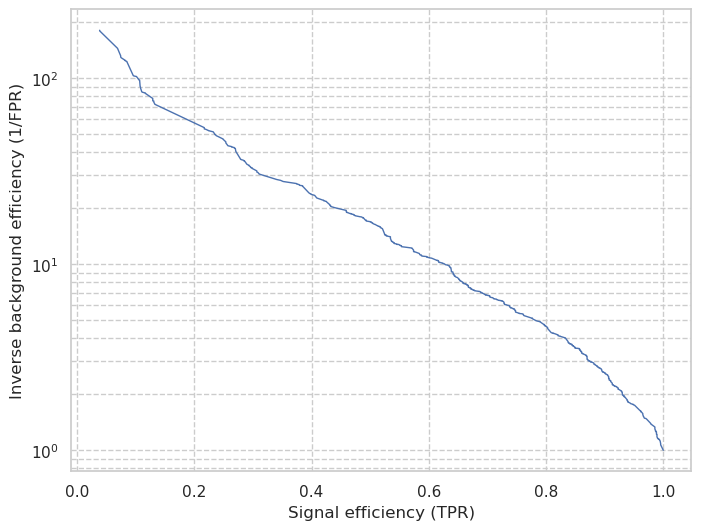

1115 118259


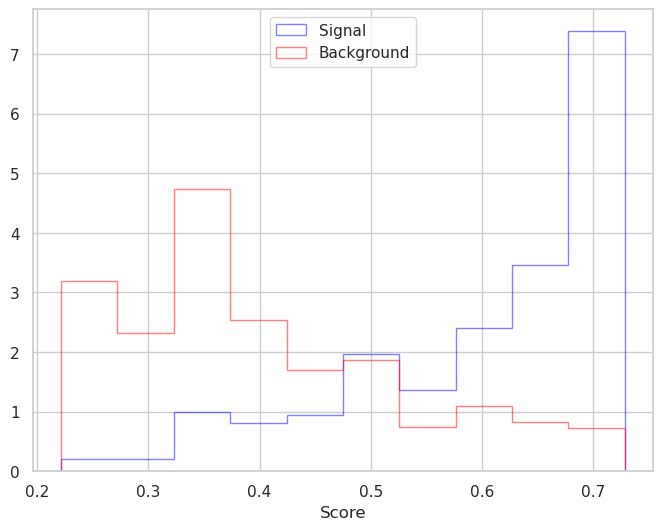

In [108]:
# plot the ROC curve
# print(bdt.predict_proba(X_test).shape)
# print(bdt.predict_proba(X_test))
print(X_test)
y_pred = bdt.predict_proba(X_test)[:, 1]
print(y_pred)
# fpr, tpr, thresholds = roc_curve(y_test, y_pred, sample_weight=weights_test)
# roc_auc = roc_auc_score(y_test, y_pred, sample_weight=weights_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'(AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='k', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(tpr, 1/fpr, lw=1)
plt.xlabel('Signal efficiency (TPR)')
plt.ylabel('Inverse background efficiency (1/FPR)')
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()

print(len(y_pred[y_test == 1]), len(y_pred[y_test == 0]))

signal_scores = y_pred[y_test == 1]
background_scores = y_pred[y_test == 0]
plt.figure(figsize=(8, 6))
plt.hist(signal_scores, bins=10, alpha=0.5, color='blue', label='Signal', histtype='step', density=True)
plt.hist(background_scores, bins=10, alpha=0.5, color='red', label='Background', histtype='step', density=True)
plt.xlabel('Score')
# plt.yscale('log')
plt.legend(loc='upper center')
plt.grid(True)
plt.show()

In [29]:
# save bdt model to json file
bdt.save_model('./xgb_model.txt')

/global/homes/a/agarabag/.conda/envs/ditau/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [16:57:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [28]:
booster = bdt.get_booster()
booster.dump_model('xgboost_model_one_boost.txt')

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

start = time.time()

learning_rate = 0.0001
batch_size = 256
dropout = 0.1
neuron1 = 32
neuron2 = 125
# neuron3 = 512
neuron4 = 125
neuron5 = 32


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
# weights_train_tensor = torch.tensor(weights_train.values, dtype=torch.float32).to(device)

X_val_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

# Define the Dataset
class SignalBackgroundDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        # self.weights = weights

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Define the DNN model with dropout
class DNN(nn.Module):
    def __init__(self, input_size):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, neuron1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(neuron1, neuron2)
        self.fc3 = nn.Linear(neuron2, neuron4)
        # self.fc4 = nn.Linear(neuron3, neuron4)
        self.fc5 = nn.Linear(neuron4, neuron5)
        self.fc6 = nn.Linear(neuron5, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        # x = self.relu(self.fc4(x))
        # x = self.dropout(x)
        x = self.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc6(x))
        return x

model = DNN(X_train_tensor.shape[1]).to(device)
criterion = nn.BCELoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader for training data
train_dataset = SignalBackgroundDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = SignalBackgroundDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 60
patience = 6  # How many epochs to wait after last time validation loss improved.
best_val_loss = np.inf  # Initialize best validation loss to infinity
epochs_no_improve = 0  # Counter for epochs with no improvement

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions, total_predictions = 0, 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        # loss = (loss * batch_weights).mean()
        loss = loss.mean()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # binary classification for accuracy calculation
        preds = outputs.squeeze().round()
        correct_predictions += (preds == targets).sum().item()
        total_predictions += targets.size(0)

    train_accuracy = correct_predictions / total_predictions
    avg_training_loss = running_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct_predictions, total_predictions = 0, 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            # loss = (loss * batch_weights).mean()
            loss = loss.mean()

            val_running_loss += loss.item()

            preds = outputs.squeeze().round()
            correct_predictions += (preds == targets).sum().item()
            total_predictions += targets.size(0)

    val_accuracy = correct_predictions / total_predictions
    avg_val_loss = val_running_loss / len(val_loader)

#     # Log metrics to W&B
#     wandb.log({
#         'epoch': epoch,
#         'training_loss': avg_training_loss,
#         'validation_loss': avg_val_loss,
#         'training_accuracy': train_accuracy,
#         'validation_accuracy': val_accuracy
#     })

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_training_loss:.4e}, Validation Loss: {avg_val_loss:.4e}, Training Accuracy: {train_accuracy:.4e}, Validation Accuracy: {val_accuracy:.4e}")

    # Check if the validation loss improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save the model
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            break  # Early stopping


# Evaluate on the validation set
model.eval()
val_predictions = []
with torch.no_grad():
    for inputs, targets in DataLoader(SignalBackgroundDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False):
        inputs = inputs.to(device)
        outputs = model(inputs).squeeze()
        val_predictions.extend(outputs.cpu().numpy())
val_predictions = np.array(val_predictions)

# Compute ROC curve and ROC area
fpr_mlp, tpr_mlp, _ = roc_curve(y_test.values, val_predictions)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

plt.figure(figsize=(22, 10))
plt.subplot(121)
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.5f})'.format(roc_auc_mlp))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot(tpr_mlp, 1/fpr_mlp, color='black', lw=1)
plt.xlabel('Signal efficiency (TPR)')
plt.ylabel('Inverse backround efficiency (1/FPR)')
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()

print(f'Pytorch Time: {(time.time() - start)/60} min')

Epoch 1/60, Training Loss: 9.1804e-02, Validation Loss: 7.2986e-02, Training Accuracy: 9.8607e-01, Validation Accuracy: 9.8777e-01
Epoch 2/60, Training Loss: 7.6560e-02, Validation Loss: 7.6757e-02, Training Accuracy: 9.8853e-01, Validation Accuracy: 9.8777e-01
Epoch 3/60, Training Loss: 7.3737e-02, Validation Loss: 7.3780e-02, Training Accuracy: 9.8854e-01, Validation Accuracy: 9.8777e-01
Epoch 4/60, Training Loss: 7.2939e-02, Validation Loss: 7.2420e-02, Training Accuracy: 9.8854e-01, Validation Accuracy: 9.8777e-01


KeyboardInterrupt: 

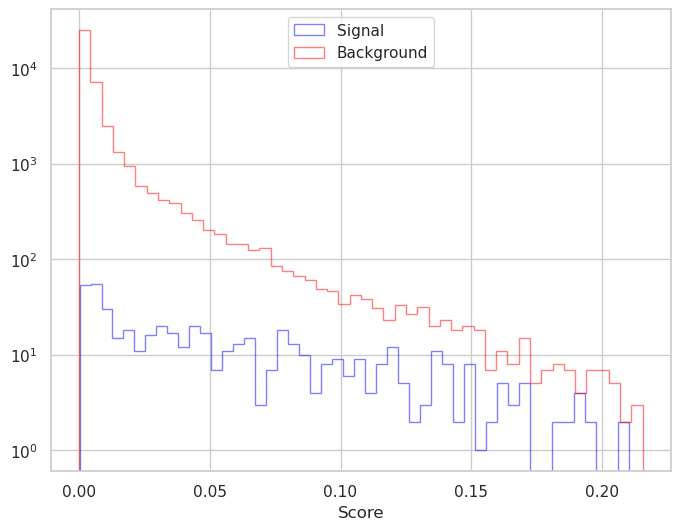

In [60]:
# plot score distribution from MLP
signal_scores = val_predictions[y_test == 1]
background_scores = val_predictions[y_test == 0]
plt.figure(figsize=(8, 6))
plt.hist(signal_scores, bins=50, alpha=0.5, color='blue', label='Signal', histtype='step')
plt.hist(background_scores, bins=50, alpha=0.5, color='red', label='Background', histtype='step')
plt.xlabel('Score')
plt.yscale('log')
plt.legend(loc='upper center')
# plt.grid(True)
plt.show()
